## Plot spatial variance of all terms 

In [1]:
import matplotlib.colors as mcolors
from matplotlib import cm,gridspec,rc
import matplotlib.pyplot as plt
import os
import warnings
import numpy as np
import xarray as xr
import tools_corrstats
import cmcrameri.cm as cmc
warnings.filterwarnings('ignore')

In [2]:
USER = os.environ['USER']
a1,a2,b1,b2 = [240,380,125,320]

In [3]:
path = f'/glade/work/{USER}/MAPP/ETOPO'
filename = f'{path}/Etopo1_Bed_0_65N_170E_40W.nc'
bathy = xr.open_dataset(filename)
lon_e = bathy['lon']
for ii in range(len(lon_e)):
    if lon_e[ii] > 0:
        lon_e[ii] = lon_e[ii] - 360.
lat_e = bathy['lat'][300:]
depth_e = bathy['depth'][300:, :]

In [4]:
mask_bathy = (depth_e >= 0.)*1.
mask_bathy = np.ma.array(mask_bathy,mask=mask_bathy==0.)
lon_e,lat_e = np.meshgrid(lon_e,lat_e)
lon_e = np.ma.array(lon_e,mask=mask_bathy.mask)
lat_e = np.ma.array(lat_e,mask=mask_bathy.mask)

In [5]:
datadir = '/glade/campaign/cesm/collections/CESM1-DPLE/DPLE-FOSI/rerun_with_extension/timeseries'
filename = f'{datadir}/g.DPLE.GECOIAF.T62_g16.009.chey.pop.h.TEMP.024901-031812.nc'
dset = xr.open_dataset(filename)
lon = dset['TLONG'].isel(nlat=range(a1, a2), nlon=range(b1, b2)) - 360.
lat = dset['TLAT'].isel(nlat=range(a1, a2), nlon=range(b1, b2))
dset.close()

In [6]:
lat_min = 15;   lat_max = 65
lon_min = -190; lon_max = -40
#
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
#csfont = {'fontname':'Times New Roman'}

## LME Shapes

In [7]:
path = f'/glade/u/home/{USER}/O2prediction/Prediction/notebooks/data'
filename = '%s/LME_shapes.gmt' % path
file1 = open(filename,'r')
lines = file1.readlines()
#
nbox = -1
lonn = [[] for ii in range(194)]
latt = [[] for ii in range(194)]
ln = 9
for line in lines[ln:]:
    sl = line.split()
    if len(sl)==2 and sl[0] == '#':
        nbox = nbox + 1
    elif len(sl)==2 and sl[0] != '#':
        lonn[nbox-1].append(np.float(sl[0]))
        latt[nbox-1].append(np.float(sl[1]))
##
pp180 = []
for pp in range(len(lonn)):
    if len(lonn[pp])>0:
        if np.min(lonn[pp])>0:
            lon1 = np.array(lonn[pp]) - 360.
        else:
            lon1 = np.array(lonn[pp])
        if len(np.where(np.abs(lon1 + 180.)<1e-4)[0])>0:
            if len(lonn[pp])<4:
                pp180.append(pp)
##
lon0 = []
lat0 = []
nn = 0
for pp in range(len(lonn)):
    if len(lonn[pp])!=0:
        nn = nn + 1
        if np.min(lonn[pp])>0:
            lon1 = np.array(lonn[pp]) - 360.
        else:
            lon1 = np.array(lonn[pp])
        lat1 = np.array(latt[pp])
        lon1 = np.ma.array(lon1,mask=False)
        lat1 = np.ma.array(lat1,mask=False)
        if pp in pp180[1:]:
#        if len(np.where(np.abs(lon1+180.)<1e-4)[0]) > 0:
            #print(pp)
            aa = np.where(np.abs(lon1+180.)<1e-4)[0]
            lon1.mask[aa] = True
            lat1.mask[aa] = True
        lon0.append(lon1)
        lat0.append(lat1)

In [8]:
def mask_nan(var):
    """
    mask nan values
    """
    maskn = np.isnan(var)
    var = np.ma.array(var,mask=maskn)
    return var

In [9]:
terms = ["Phi'",'O2','T','S','AOU','O2sol','Resi','O2-T','O2-S','O2-Resi','T-S','AOU-T','O2sol-T','T-Resi','AOU-S','O2sol-S','S-Resi','AOU-O2sol','AOU-Resi','O2sol-Resi']

In [10]:
cmin = -.02;cmax = .02;clev = 40.
dc = (cmax - cmin)/clev; vct = np.arange(cmin, cmax+dc, dc)
pal_normt = mcolors.BoundaryNorm(vct, ncolors=256, clip = False)

0 5.060483390789694e-05 0.05518552989606667
1 6.019876429356391e-06 0.07070228843126358
2 1.7219290965855124e-06 0.022316327237880986
3 -0.03689709283196665 0.01880598970936699
4 -0.013911456462270731 0.004198805485659738
5 1.6384179629697549e-06 0.026149435342961717
6 1.3120363332011716e-07 0.02381991815836659
7 -0.02869079812484396 0.033827437889559386
8 -0.03933342810600676 0.013004327699025877
9 -0.013781564644017658 0.032552626168365434


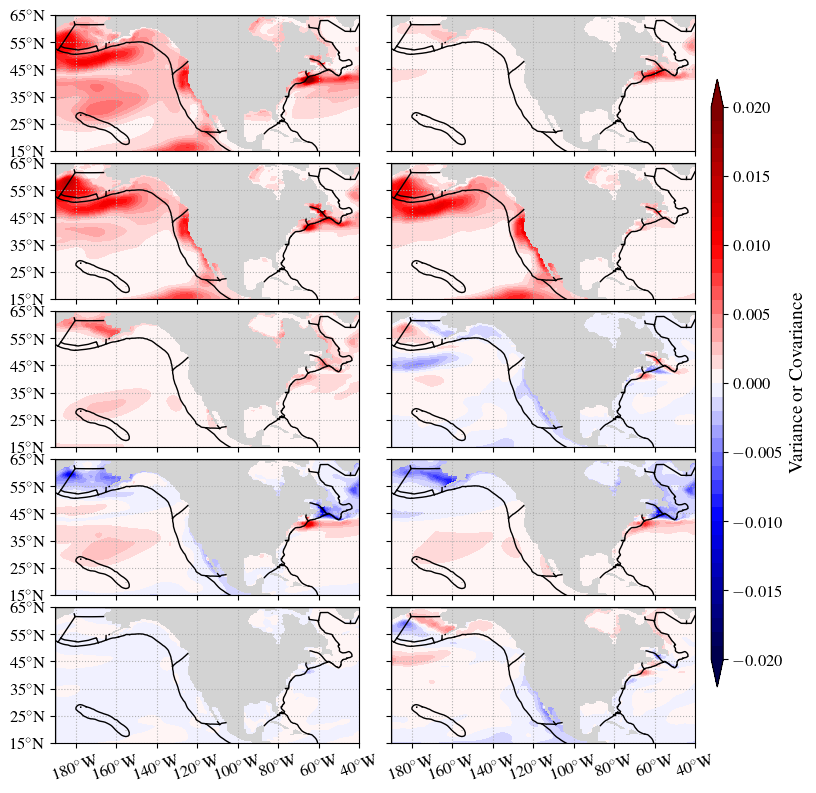

In [11]:
path = f'/glade/scratch/{USER}/DPLE-results'
#
nphi = 1
#for layer in ['0-200m', '200-600m']:
for layer in ['0-200m']:
    fig = plt.figure(figsize=[8, 8])
    gs = gridspec.GridSpec(4, 2)#, width_ratios=[1, 1, 1, 1e-2])
    # read ACC data
    # Persistence and DPLE ACC
    filename = f'{path}/FOSI_hindcast_spatial_distribution_of_variance_Phi_components_{layer}.nc'
    ds = xr.open_dataset(filename)
    vari = ds['variance'].values[nphi,:] # 20,nlat,nlon
    ## plot
    for gg, mm, tit in [[0, 0, "$\Phi'$"], [1, 1, 'O$_2$'], [2, 2, 'T'], [3, 7, 'O2-T'], [4, 6, 'Residual'], \
                    [5, 5, 'O2sol'], [6, 4, 'AOU'], [7, 17, 'O2sol-AOU'], [8, 12, 'O2sol-T'], [9, 11,'AOU-T']]:
        xj = int(np.floor(gg/5))
        xi = gg - xj*5

        ax = fig.add_axes([0.06+xj*0.42, 0.05+(4-xi)*0.185, 0.38, 0.17])
        #
        xrr = np.arange(lon_min-10, lon_max+10)
        ax.fill_between(xrr, np.ones(len(xrr))*(lat_min-10), np.ones(len(xrr))*(lat_max+10), color='lightgray', zorder=0)
        for pp in range(len(lon0)):
            ax.plot(lon0[pp], lat0[pp], color='k', linewidth=1., zorder=19)

        if gg != 4 :
            cd = ax.contourf(lon, lat, vari[mm], vct, shading='nearest', cmap=cm.seismic, norm=pal_normt, extend='both')
            print(gg,np.nanmin(vari[mm]), np.nanmax(vari[mm]))
        else:
            #vv = vari[mm,ldd] + vari[9,ldd] + vari[13,ldd] + vari[16,ldd] + vari[3,ldd] + vari[8,ldd] + vari[10,ldd]
            vv = vari[0] - (vari[1] + vari[2] + vari[7])
            cd = ax.contourf(lon, lat, vv, vct, shading='nearest', cmap=cm.seismic, norm=pal_normt, extend='both')
            print(gg,np.nanmin(vv), np.nanmax(vv))

        #ax.pcolor(lon_e,lat_e,mask_bathy,shading='nearest',cmap=cm.terrain_r,vmin=.5,vmax=4,zorder=20)
        ax.set_xlim(lon_min, lon_max)
        ax.set_ylim(lat_min, lat_max)
        ax.set_xticks(np.arange(-180, -30, 20))
        ax.set_yticks(np.arange(15, 66, 10))
        #
        xtl = []
        for ii in np.arange(-180, -30, 20):
            if ii < -180:
                ii = ii + 360
                ff = 'E'
            elif ii >= -180:
                ff = 'W'
            elif np.abs(ii-0) < 1e-5:
                ff = ''
            xtl.append('%d$^\circ$%s' % (abs(ii), ff))
        ytl = []
        for jj in np.arange(15, 66, 10):
            if jj < 0:
                ff = 'S'
            elif jj > 0:
                ff = 'N'
            elif np.abs(jj-0) < 1e-5:
                ff = ''
            ytl.append('%d$^\circ$%s' % (abs(jj), ff))
        if gg in [4,9]:
            ax.set_xticklabels(xtl, fontsize=12, fontweight='bold', rotation=20)
        else:
            ax.set_xticklabels([], fontsize=12, fontweight='bold', rotation=20)
        if gg < 5:
            ax.set_yticklabels(ytl, fontsize=12, fontweight='bold')
        else:
            ax.set_yticklabels([], fontsize=12, fontweight='bold')
        ax.plot([lon_min, lon_max], [lat_max, lat_max], color='k', linewidth=1, zorder=10)
        ax.plot([lon_min, lon_min], [lat_min, lat_max], color='k', linewidth=1, zorder=10)
        ax.grid(linestyle='dotted', zorder=11)
        # colorbar
        if gg == 0 and mm == 0:
            cbaxes = fig.add_axes([0.88, 0.12, 0.015, 0.76])
            cb = plt.colorbar(cd, orientation="vertical", cax=cbaxes, extend='max', ticks=np.arange(-.02,.021,5e-3))
            cb.ax.tick_params(labelsize=12)
            cb.set_label(label='Variance or Covariance', fontsize=14, fontweight='bold')
    #
    output = f'/glade/scratch/{USER}/DPLE-plots'
    outfile = f'{output}/FOSI_spatial_Phi_components_variance_{nphi}_{layer}.png'
    plt.savefig(outfile, dpi=400)
plt.show()